<a href="https://colab.research.google.com/github/KazGet/Summer_prac/blob/main/Summer_practies_3_2_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive; drive.mount('/content/drive')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, label_binarize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
!pip install missforest
from missforest import MissForest
!pip install optuna
import optuna
import shap
!pip install boruta
from boruta import BorutaPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
file = "/content/3_task.xlsx"
df = pd.read_excel(file, sheet_name=2)
#Предсказание попадания пациента в группу 3 по данным стресс-ЭхоКГ — графы СR-GJ
df = df.rename(columns={'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +': 'Phenotype_angio'})

categorical_features = ['Reason of Stress Stop',	'Peak ECG']
df[categorical_features] = df[categorical_features].fillna("NaN").astype(str)

df['target'] = (df['Phenotype_angio'] == 3).astype(int)
df.drop(['Phenotype_angio'], axis=1, inplace=True)
X = df.drop('target', axis=1)
y = df['target']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
X.columns = X.columns.astype(str)
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [ ]:
# @title Удаление полупустых признаков и заполнение медианой
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.3].index
df_dropped = df.drop(cols_to_drop, axis=1)

X_dropped = df_dropped.drop('target', axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_dropped[categorical_features] = encoder.fit_transform(X_dropped[categorical_features])

imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X_dropped)
X_filled_data = pd.DataFrame(X_filled, columns=X_dropped.columns)

In [ ]:
# @title Заполнение методом KNNImputer
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X)

imputer = KNNImputer(n_neighbors=15)
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_KNN = scaler.inverse_transform(df_imputed_scaled)
df_final = pd.DataFrame(df_KNN, columns=X.columns)

In [ ]:
# @title Заполнение пропусков методом Iterative Imputer
imputer = IterativeImputer(max_iter=25, random_state=0)
df_imputed = imputer.fit_transform(X)
df_MICE = pd.DataFrame(df_imputed, columns=X.columns)

In [ ]:
# @title Заполнение пропусков методом MissForest
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_miss_forest = mf.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [13:05<00:00, 157.15s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process

X_med: Компоненты, объясняющие 95% дисперсии = 36
df_KNN: Компоненты, объясняющие 95% дисперсии = 45
df_MICE: Компоненты, объясняющие 95% дисперсии = 42
df_MissForest: Компоненты, объясняющие 95% дисперсии = 45


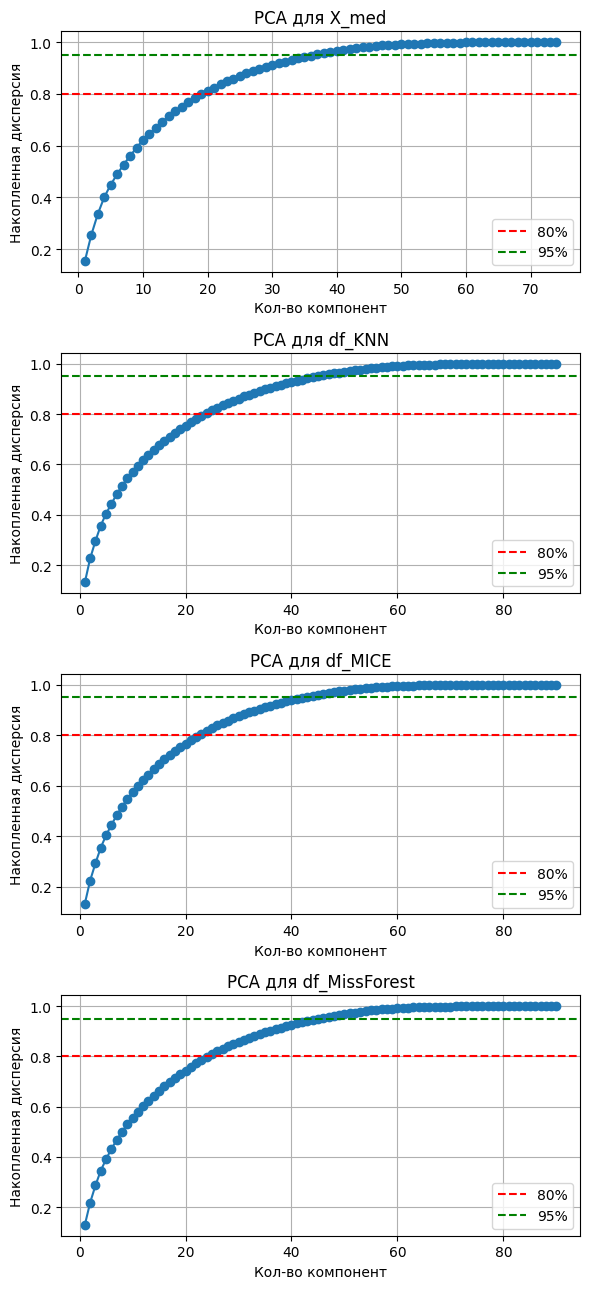

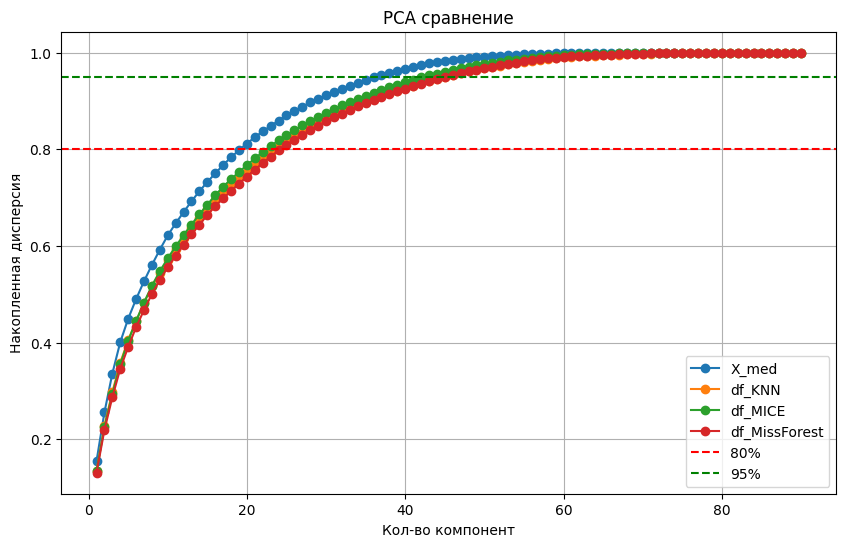

In [ ]:
# @title PCA
fig, axes = plt.subplots(4, 1, figsize=(6, 13))

datasets = [
    ("X_med", X_filled_data),
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


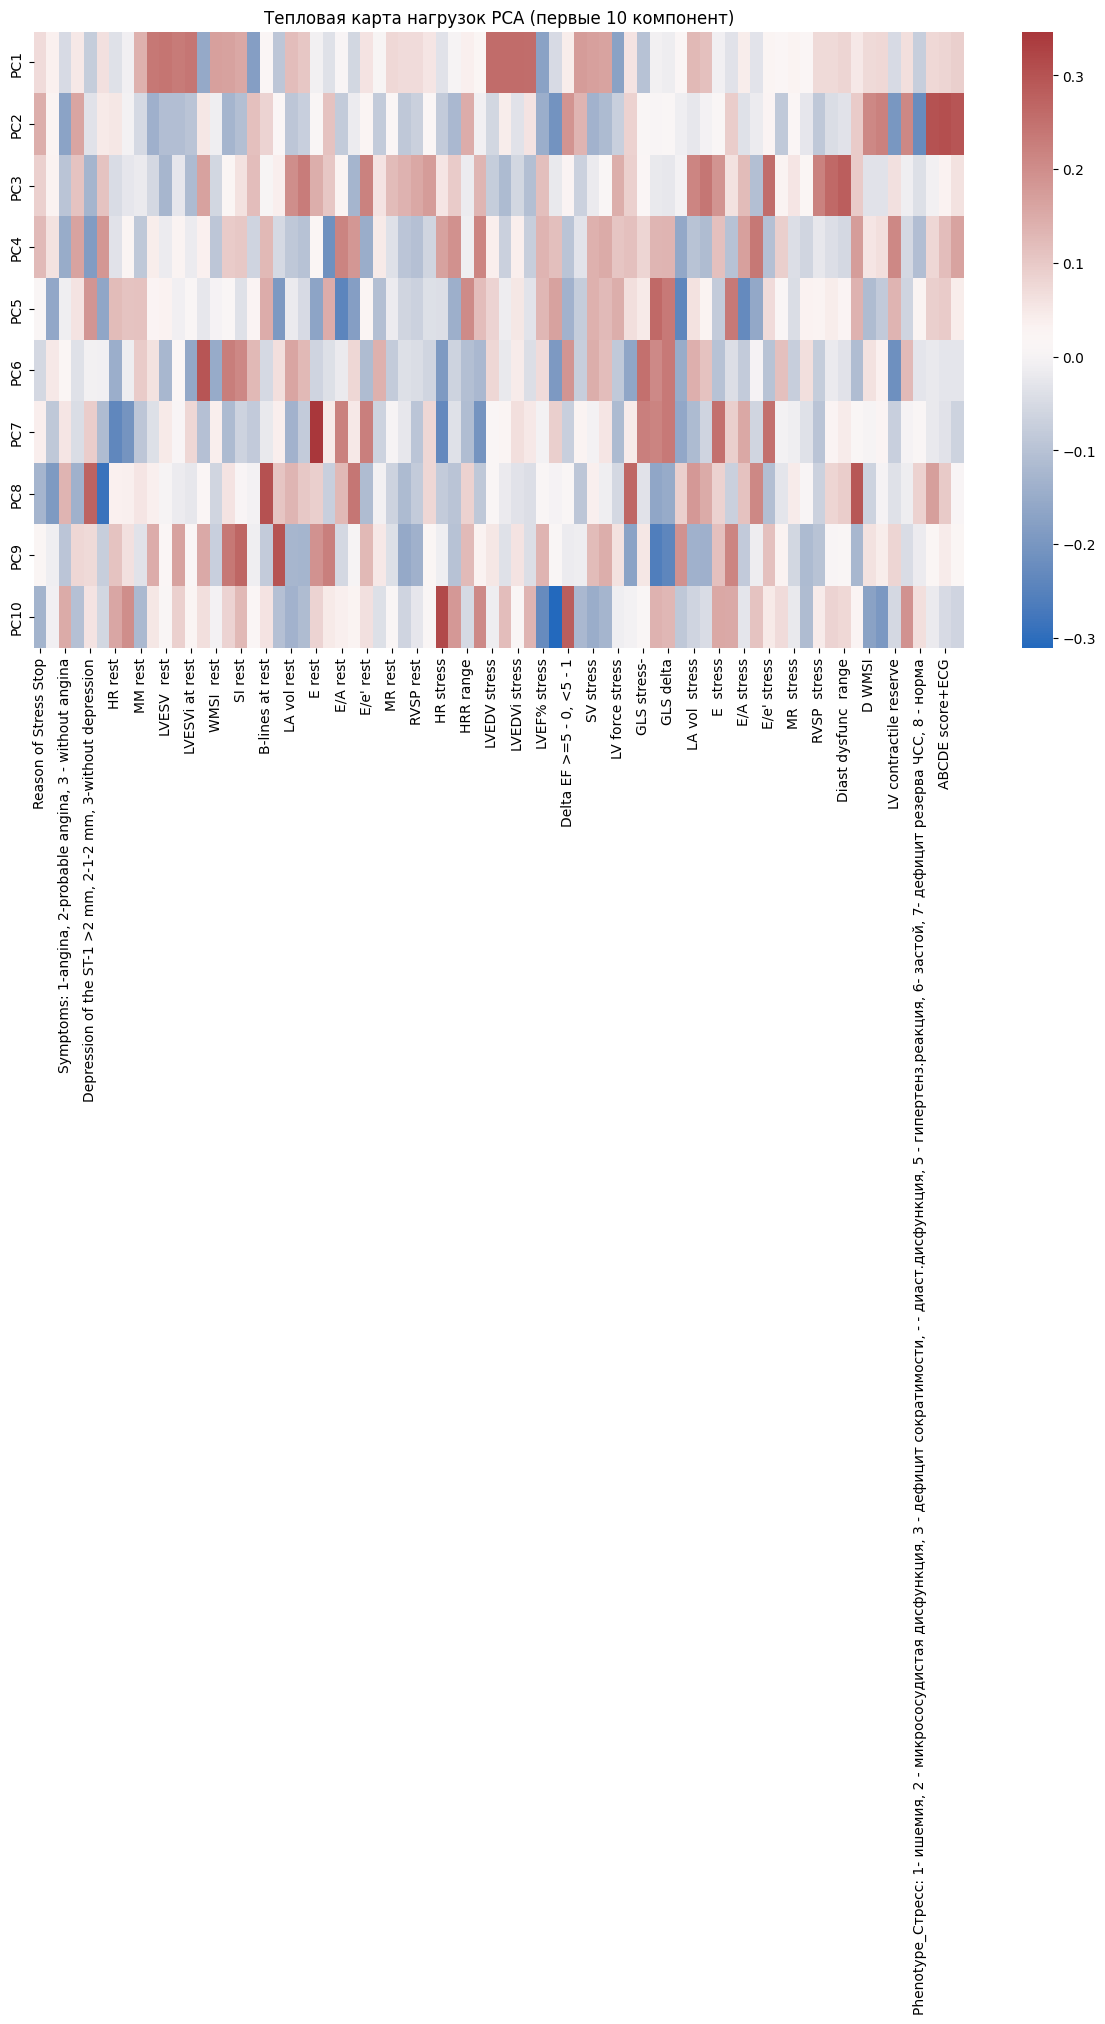

In [ ]:
# @title Отбор признаков по матрице весов PCA
X_numeric = X_filled_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]

# Визуализируем нагрузки для первых 10 компонент
plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False) # annot=True, если признаков не слишком много
plt.title('Тепловая карта нагрузок PCA (первые 10 компонент)')
plt.show()

In [ ]:
# @title Рекурсивное исключение признаков (Recursive Feature Elimination, RFE): Модель обучается на всех признаках, затем самый неважный удаляется, и процесс повторяется.
select_num = 9
selector_med = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_med.fit(X_filled, y)
selected_features_med = X_dropped.columns[selector_med.get_support()]
print("Отобранные признаки для данных, заполенными медианой: ")
print(selected_features_med.tolist())

selector_KNN = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_KNN.fit(df_KNN, y)
selected_features_KNN = X.columns[selector_KNN.get_support()]
print(f"Отобранные признаки для данных, заполенными методом ближайших соседей: ")
print(selected_features_KNN.tolist())

selector_MICE = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MICE.fit(df_MICE, y)
selected_features_MICE = X.columns[selector_MICE.get_support()]
print(f"Отобранные признаки для данных, заполенными методом итеративного заполнения: ")
print(selected_features_MICE.tolist())

selector_MissF = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MissF.fit(df_miss_forest, y)
selected_features_MissF = X.columns[selector_MissF.get_support()]
print(f"Отобранные признаки для данных, заполенными методом MissForest: ")
print(selected_features_MissF.tolist())

print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE) & set(selected_features_MissF))

Отобранные признаки для данных, заполенными медианой: 
['MM rest', 'LVEF% at rest', 'HRR', 'LVESVi stress', 'LVEF% stress', 'WMSI stress', 'GLS stress-', 'D WMSI', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']
Отобранные признаки для данных, заполенными методом ближайших соседей: 
['MM rest', 'LAD at rest', 'LA vol rest', 'LVESVi stress', 'WMSI stress', 'GLS stress-', 'DTE stress', 'D WMSI', 'CFVR']
Отобранные признаки для данных, заполенными методом итеративного заполнения: 
['GLS rest', 'LA vol rest', 'LVEF% stress', 'delta EF', 'WMSI stress', 'GLS stress-', 'DTE stress', 'D WMSI', 'CFVR']
Отобранные признаки для данных, заполенными методом MissForest: 
['DBP rest', 'LVESV  rest', 'LVESVi at rest', 'RAVI rest', "a' rest", 'HR stress', 'SI stress', "E/e' stress", 'TR vel  stress']

Пересечение всех признаков: 
set()


In [ ]:
print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE))


Пересечение всех признаков: 
{'WMSI stress', 'D WMSI', 'GLS stress-'}


In [ ]:
# @title Отбор признаков методом Boruta
dfrf = df_MICE
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

feat_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=200,
    random_state=0,
    verbose=False
)

feat_selector.fit(dfrf.values, y.values)

selected_mask = feat_selector.support_
selected_features = dfrf.columns[selected_mask]

print("\nОтобранные признаки методом Boruta:")
print(selected_features.tolist())


Отобранные признаки методом Boruta:
['WMSI stress', 'GLS stress-', 'DTE stress', 'D WMSI', 'WMSI range', 'CFVR', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']


In [ ]:
# @title RFECV —  RFE с автоматическим выбором числа признаков через кросс-валидацию
df_test = df_MICE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=RandomForestClassifier(), step=1, cv=cv, scoring='accuracy', n_jobs=-1)
selector.fit(df_test, y)
selected_features = df_test.columns[selector.get_support()]
print("Оптимальное число признаков:", selector.n_features_)
print("Отобранные признаки:", selected_features.tolist())

Оптимальное число признаков: 50
Отобранные признаки: ['MM rest', 'LVEDV rest', 'LVESV  rest', 'LVEF% at rest', 'SV rest', 'LAD at rest', 'GLS rest', 'LA vol rest', 'LAVI rest', 'RAVI rest', 'E/A rest', 'DTE rest', 'TAPSE rest', 'S RV rest', 'TR vel rest', 'RVSP rest', 'HR stress', 'HRR', 'SBP stress', 'LVESV stress', 'LVEDVi stress', 'LVESVi stress', 'LVEF% stress', 'delta EF', 'WMSI stress', 'SI stress', 'LV force stress', 'LAD stress', 'GLS stress-', 'GLS reserve', 'GLS delta', 'LA vol  stress', 'RA vol stress', 'RAI stress', 'E  stress', 'E/A stress', 'DTE stress', "a'  stress", "s'  stress", "E/e' stress", 'TAPSE  stress', 'TR vel  stress', 'D WMSI', 'WMSI range', 'LV contractile reserve', 'CFVR', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']


In [ ]:
# @title Отбор признаков методом ANOVA: оценка стат. связи между каждым признаком и целевой переменной
datasets = {
    "медианой": (X_filled, X_dropped.columns),
    "KNN": (df_KNN, X.columns),
    "MICE": (df_MICE, X.columns),
    "MF": (df_miss_forest, X.columns),
}

selected_features_all = {}

for name, (X_data, feature_names) in datasets.items():
    selector = SelectKBest(score_func=f_classif, k=select_num)
    X_selected = selector.fit_transform(X_data, y)
    selected = feature_names[selector.get_support()]
    selected_features_all[name] = set(selected)
    print(f"Отобранные признаки с данными {name}:\n{list(selected)}")


print("\nПересечение всех результатов (медиана ∩ KNN ∩ MICE):")
print(list(
    selected_features_all["медианой"]
    & selected_features_all["KNN"]
    & selected_features_all["MICE"]
))

Отобранные признаки с данными медианой:
['LVESV stress', 'LVESVi stress', 'WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными KNN:
['LVESV stress', 'WMSI stress', 'D WMSI', 'WMSI range', 'СFVR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MICE:
['LVESV stress', 'LVESVi stress', 'WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score'

In [ ]:
# @title Отбор по LassoCV
def run_lasso_selection(X_source, y, name, feature_names):
    # Стандартизация + подбор alpha через кросс-валидацию
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(cv=5, max_iter=10000))
    ])

    pipeline.fit(X_source, y)
    best_alpha = pipeline.named_steps['lasso_cv'].alpha_

    print(f"\n{name}: наилучшее значение alpha = {best_alpha:.4f}")

    # Финальная модель с выбранным alpha
    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    X_scaled = StandardScaler().fit_transform(X_source)
    lasso.fit(X_scaled, y)

    # Отбор ненулевых коэффициентов
    non_zero_coefs = np.where(lasso.coef_ != 0)[0]
    selected = feature_names[non_zero_coefs]

    print(f"\nВыбранные признаки для {name}:\n", selected.tolist())
    return set(selected)

# Прогоним для всех способов заполнения
features_median = run_lasso_selection(X_filled, y, "Median", X_dropped.columns)
features_knn    = run_lasso_selection(df_KNN, y, "KNN", X.columns)
features_mice   = run_lasso_selection(df_MICE, y, "MICE", X.columns)
features_mf     = run_lasso_selection(df_miss_forest, y, "MissForest", X.columns)

# Пересечение всех
print("\nПересечение всех признаков:")
intersection = features_median & features_knn & features_mice & features_mf
print(intersection)



Median: наилучшее значение alpha = 0.0108

Выбранные признаки для Median:
 ['Reason of Stress Stop', 'Peak ECG', 'MM rest', 'LVEDVi at rest', 'SI rest', 'LV force rest', 'B-lines at rest', 'GLS rest', 'E rest', "e' rest", 'MR rest', 'HR stress', 'HRR', 'SBP stress', 'delta EF', 'WMSI stress', 'B-lines stress', 'GLS stress-', 'GLS reserve', 'LAVI stress', 'E  stress', 'E/A stress', "E/e' stress", 'TAPSE  stress', 'MR  stress', 'RVSP  stress', 'B range', 'D WMSI', 'WMSI range', 'LV CR range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score']

KNN: наилучшее значение alpha = 0.0308

Выбранные признаки для KNN:
 ['MM rest', 'HRR', 'WMSI stress', 'GLS stress-', 'TAPSE  stress', 'D WMSI', 'WMSI range', 'СFVR range']

MICE: наилучшее значение alpha = 0.0153

Выбранные признаки для MICE:
 ['Peak ECG', 'MM rest', 'LVEDVi at rest', 'SV rest', 'SI rest'

In [ ]:
# @title Объединение методов

#Удалим признаки с >50% пропусков
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.4].index
df_dropped = df.drop(cols_to_drop, axis=1)
X_d = df_dropped.drop('target', axis=1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_d[categorical_features] = encoder.fit_transform(X_d[categorical_features])

#Используем IterativeImputer для заполнения оставшихся признаков
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_after_MF = mf.fit_transform(X_d)

imputer = IterativeImputer(max_iter=10, random_state=0)
df_after_MICE = imputer.fit_transform(X_d)
df_after_MICE = pd.DataFrame(df_after_MICE, columns=X_d.columns)

#Масшитабируем
X_numeric = df_after_MICE.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

X_numeric_ = df_after_MF.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X_numeric_)

#Сделаем отбор по методу RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled, y)
selected_features_MICE = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MICE: ")
print(selected_features_MICE.tolist())

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled_, y)
selected_features_MF = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MF: ")
print(selected_features_MF.tolist())

#Сделаем отбор методом ANOVA
selector_ANOVA = SelectKBest(score_func=f_classif, k=select_num)
X_anova = selector_ANOVA.fit_transform(X_scaled, y)

selector_ANOVA_ = SelectKBest(score_func=f_classif, k=select_num)
X_anova_ = selector_ANOVA_.fit_transform(X_scaled_, y)

scores = selector_ANOVA.scores_
p_values = selector_ANOVA.pvalues_

scores = selector_ANOVA_.scores_
p_values = selector_ANOVA_.pvalues_

selected_featuresMICE = X_d.columns[selector_ANOVA.get_support()]
print(f"\nОтобранные признаки методом ANOVA:\n {list(selected_featuresMICE)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MICE) & set(selected_featuresMICE))

selected_featuresMF = X_d.columns[selector_ANOVA_.get_support()]
print(f"\nОтобранные признаки методом ANOVA (MF):\n {list(selected_featuresMF)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MF) & set(selected_featuresMF))

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [07:35<00:00, 91.18s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

Отобранные признаки методом RFE+MICE: 
['LVEF% at rest', 'GLS rest', 'LA vol rest', 'LVEF% stress', 'WMSI stress', 'GLS stress-', 'D WMSI', 'LV contractile reserve', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']
Отобранные признаки методом RFE+MF: 
['LVEDV rest', 'LVESVi at rest', 'E/A rest', "e' rest", 'LVEDV stress', 'LVESVi stress', 'MR  stress', 'Diast dysfunc  stress', 'ABCDE score']

Отобранные признаки методом ANOVA:
 ['LVESV stress', 'LVESVi stress', 'WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Общие признаки в RFE и ANOVA: {'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - д

In [ ]:
print(set(selected_features_MF) & set(selected_featuresMF) & set(selected_features_MICE) & set(selected_featuresMICE))

set()


In [ ]:
print(X.columns.tolist())

['Reason of Stress Stop', 'Peak ECG', 'Symptoms: 1-angina, 2-probable angina, 3 - without angina', 'Angina range', 'Depression of the ST-1 2 mm, 2-1-2 mm, 3-without depression', 'ECG range', 'HR rest', 'DBP rest', 'MM rest', 'LVEDV rest', 'LVESV  rest', 'LVEDVi at rest', 'LVESVi at rest', 'LVEF% at rest', 'WMSI  rest', 'SV rest', 'SI rest', 'LV force rest', 'LAD at rest', 'B-lines at rest', 'GLS rest', 'LA vol rest', 'LAVI rest', 'RA vol rest', 'RAVI rest', 'E rest', 'A rest', 'E/A rest', 'DTE rest', "e' rest", "a' rest", "s' rest", "E/e' rest", 'TAPSE rest', 'S RV rest', 'MR rest', 'TR vel rest', 'RVSP rest', 'Diast dysfunc rest', 'HR stress', 'HRR', 'HRR range', 'SBP stress', 'LVEDV stress', 'LVESV stress', 'LVEDVi stress', 'LVESVi stress', 'LVEF% stress', 'delta EF', 'Delta EF =5 - 0, 5 - 1', 'WMSI stress', 'SV stress', 'SI stress', 'LV force stress', 'LAD stress', 'B-lines stress', 'GLS stress-', 'GLS reserve', 'GLS delta', 'delta GLS 2 - 0, =2 - 1\n', 'LA vol  stress', 'LAVI stres

Accuracy: 0.8351648351648352
Recall: 0.7586206896551724

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        62
           1       0.73      0.76      0.75        29

    accuracy                           0.84        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.84      0.84      0.84        91


Confusion matrix:
 [[54  8]
 [ 7 22]]
ROC AUC (Train): 0.8943703755409744
ROC AUC: 0.8314794215795328


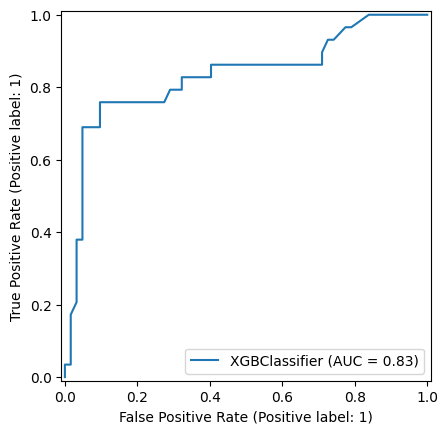

<Figure size 2000x1200 with 0 Axes>

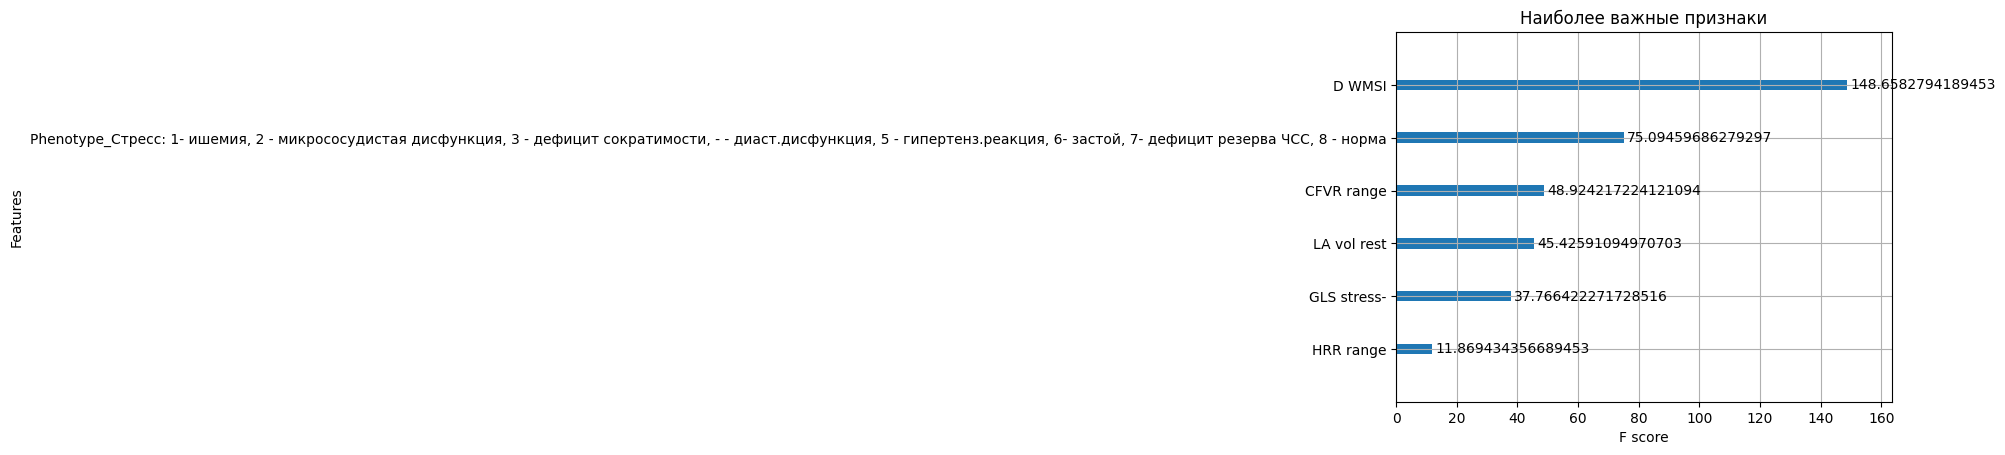

In [ ]:
# @title XGBoost

# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X[categorical_features] = encoder.fit_transform(X[categorical_features])
# X.columns = X.columns.astype(str)
# X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

optimal_cols = ['GLS stress-', 'D WMSI','СFVR range', 'LA vol rest','HRR range',
                'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']
X_boost=X[optimal_cols]

X_train, X_test, y_train, y_test = train_test_split(X_boost, y, stratify=y, random_state=42, test_size=0.2)
neg = len(y_train[y_train == 0])
pos = len(y_train[y_train == 1])
scale_pos_weight = neg / pos

params = {'max_depth': 6, 'learning_rate': 0.38830158686351, 'n_estimators': 188, 'min_child_weight': 2, 'gamma': 2.5968539032497118, 'subsample': 0.9070492409605632,
          'colsample_bytree': 0.7562826912266845, 'reg_alpha': 1.319550703563934, 'reg_lambda': 5.973831576646422, 'scale_pos_weight': scale_pos_weight}

model = XGBClassifier(**params, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

plt.figure(figsize=(20, 12))
plot_importance(model, max_num_features=len(optimal_cols), importance_type='total_gain')
plt.title("Наиболее важные признаки")
plt.show()

0:	learn: 0.6218487	total: 47.5ms	remaining: 5.47s
25:	learn: 0.8319328	total: 54.5ms	remaining: 189ms
50:	learn: 0.8655462	total: 61.2ms	remaining: 78ms
75:	learn: 0.8655462	total: 68.2ms	remaining: 35.9ms
100:	learn: 0.8655462	total: 76ms	remaining: 11.3ms
115:	learn: 0.8739496	total: 81.9ms	remaining: 0us
Accuracy: 0.7582417582417582
Recall: 0.6923076923076923

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        65
           1       0.56      0.69      0.62        26

    accuracy                           0.76        91
   macro avg       0.71      0.74      0.72        91
weighted avg       0.78      0.76      0.76        91


Confusion matrix:
 [[51 14]
 [ 8 18]]
ROC AUC (Train): 0.9088200854112136
ROC AUC: 0.8079881656804733


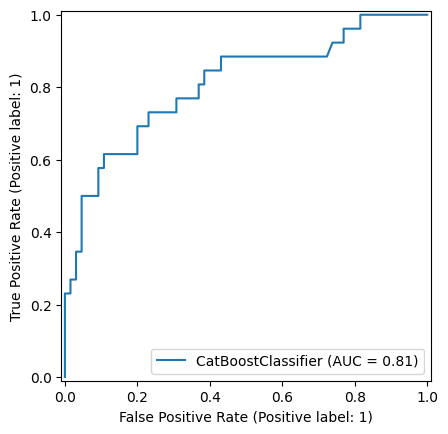

Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма: 37.2200
СFVR range: 20.2138
D WMSI: 15.0628
GLS stress-: 13.5823
LA vol rest: 8.3794
HRR range: 5.5418


In [ ]:
# @title CatBoostClassifier
# optimal_cols =  ['Dyslipidemia','LPHD_Ch','ESC Pre-test Probability', 'NYHA Class', 'Creatinine' ,'Glukosa','AF','Carotid artery disease' ]

# optimal_cols =  ['LPHD_Ch', 'Therapy: beta-blocker',  'Therapy: aspirin', 'Therapy: other antiplatelet agent', 'PCI past','Prior MI',
#                  'Carotid artery disease','ESC Pre-test Probability',]

# optimal_cols=['Dyslipidemia', 'Prior MI', 'LPHD_Ch', 'Therapy: beta-blocker', 'Therapy: other antiplatelet agent','Carotid artery disease',
#               'ESC Pre-test Probability', 'CABG',]

X_boost = X[optimal_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X_boost, y,
    test_size=0.2,
    random_state=0,
    shuffle=True
)
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

params =  {'iterations': 116, 'learning_rate': 0.10155568960633561, 'depth': 5, 'l2_leaf_reg': 9.663540417193897, 'random_strength': 8.373440044547419,
           'bagging_temperature': 0.5976094384513785, 'border_count': 203, 'scale_pos_weight': scale_pos_weight, "loss_function": "Logloss", "eval_metric": "Recall", "verbose":25}

model = CatBoostClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()


importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Вывод важности признаков
for i in range(len(X_boost.columns)):
    print(f"{X_boost.columns[indices[i]]}: {importances[indices[i]]:.4f}")

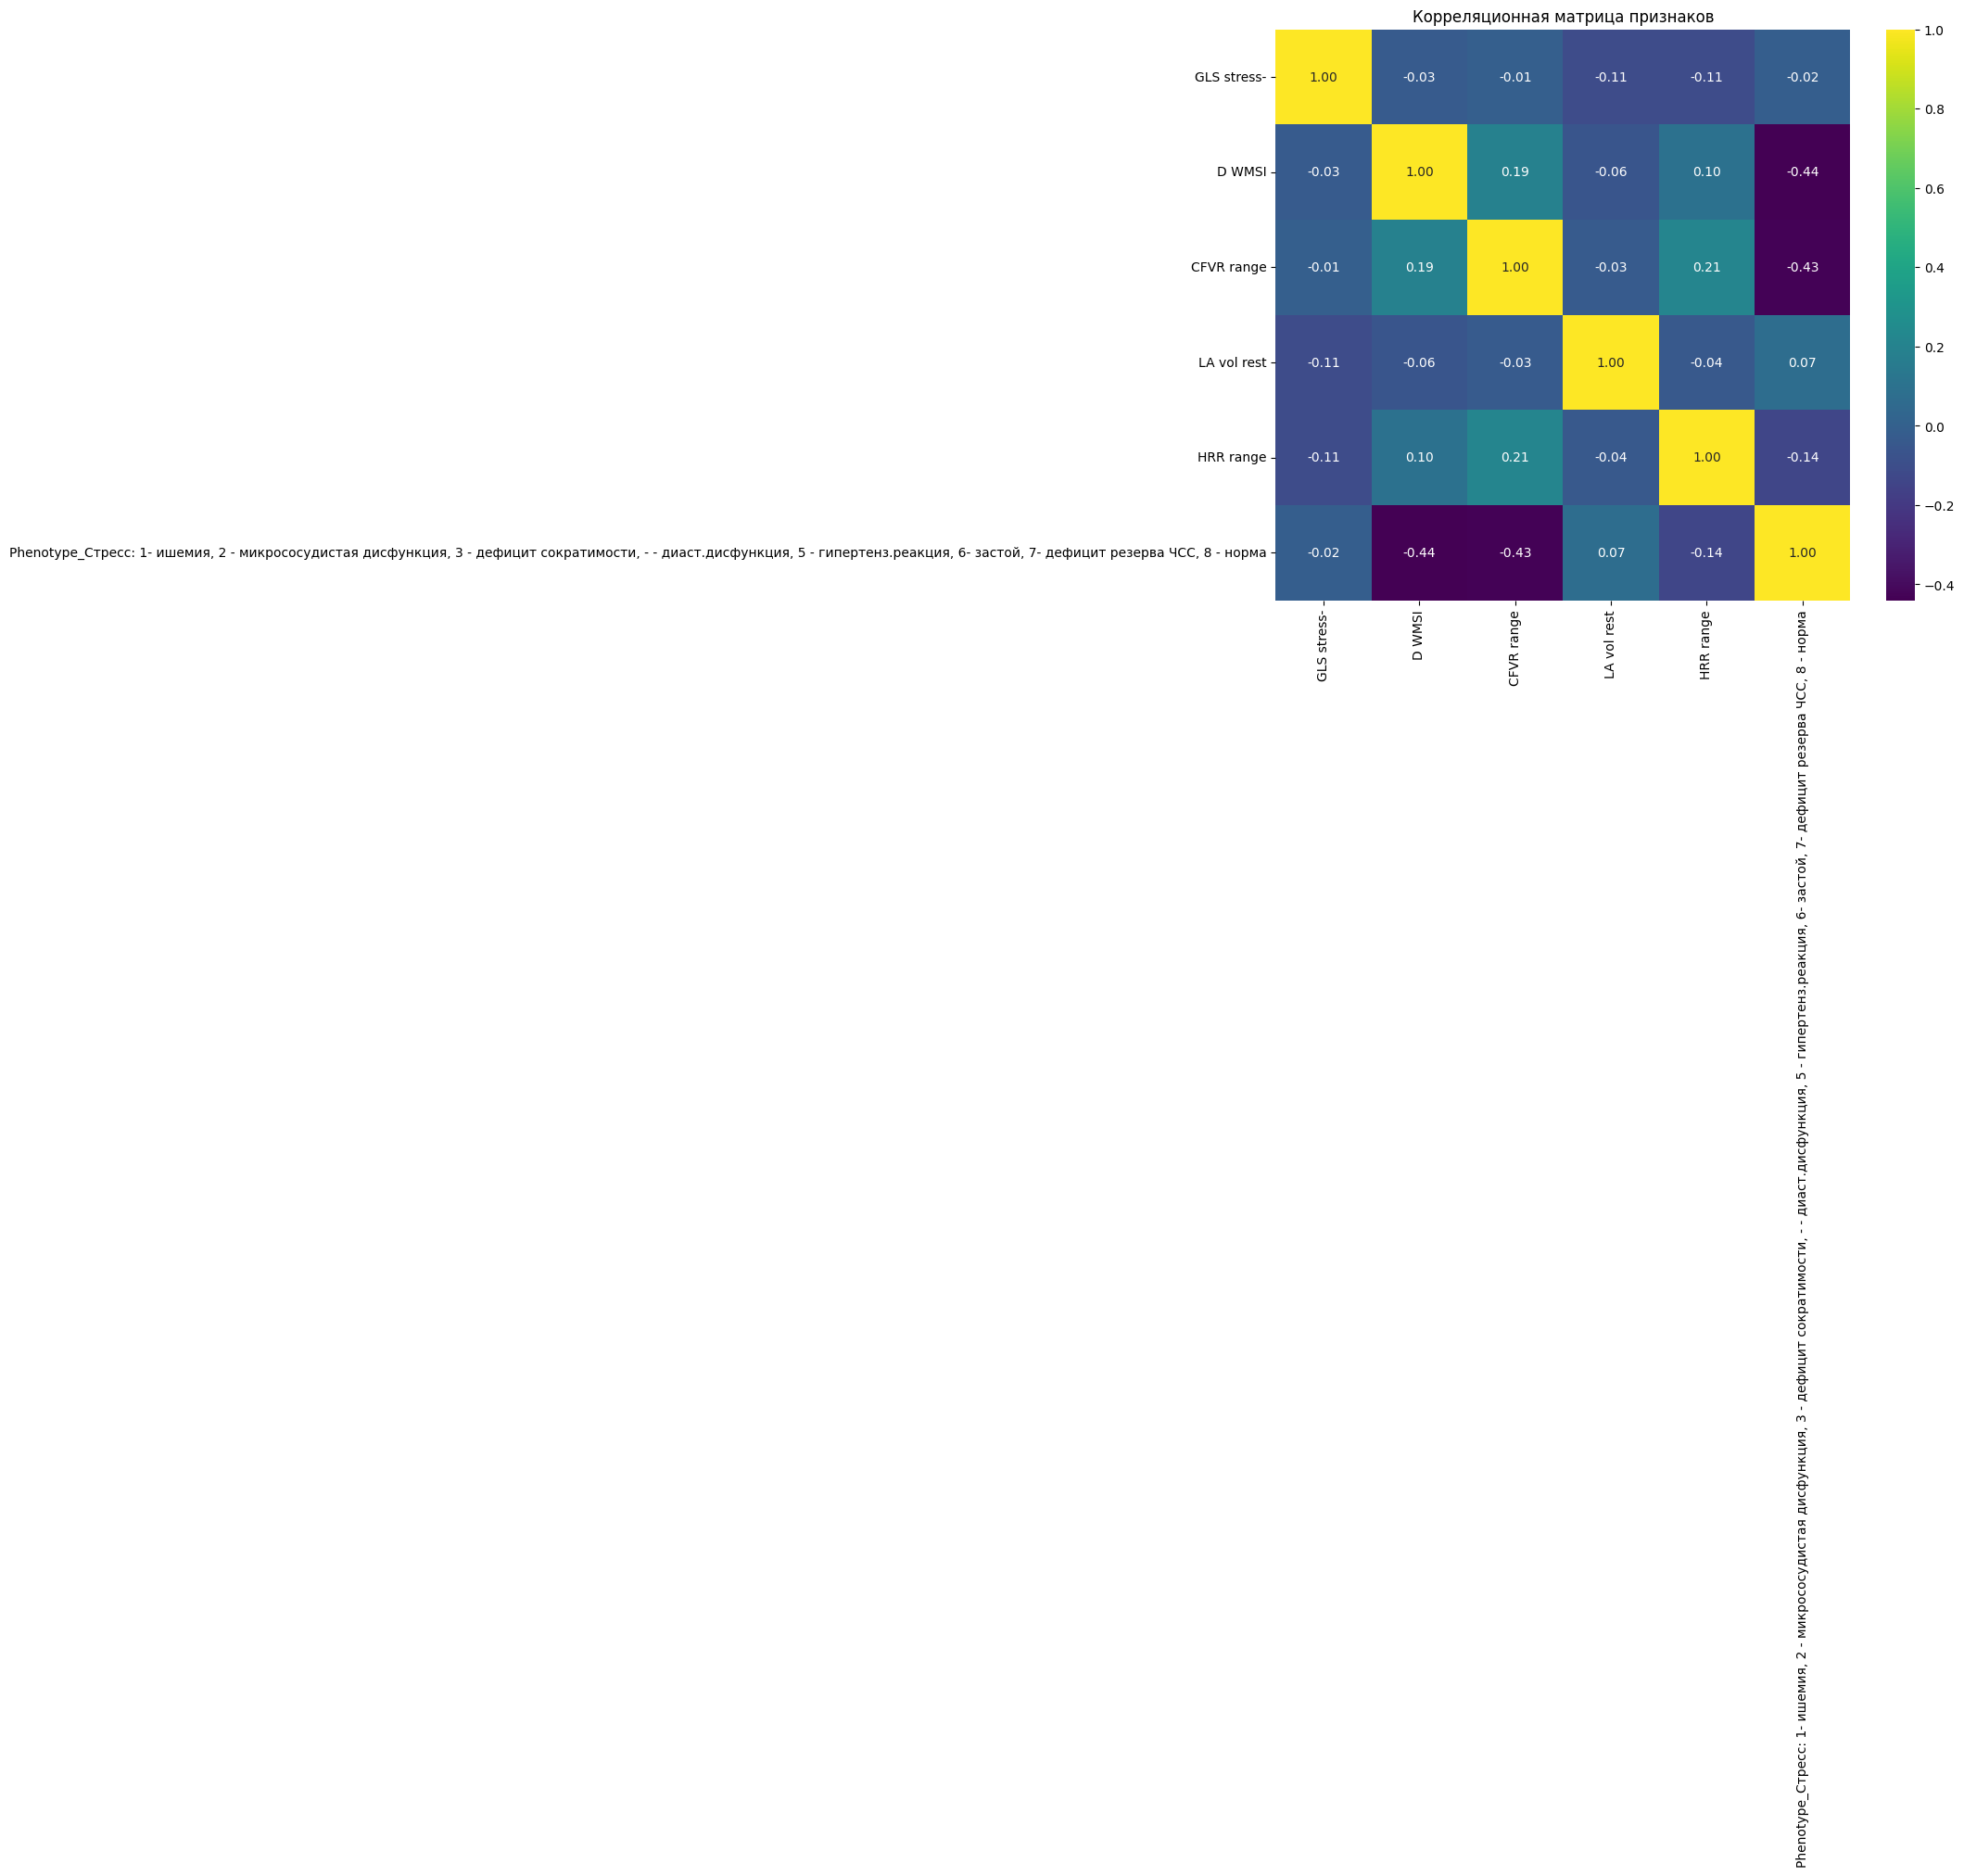

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


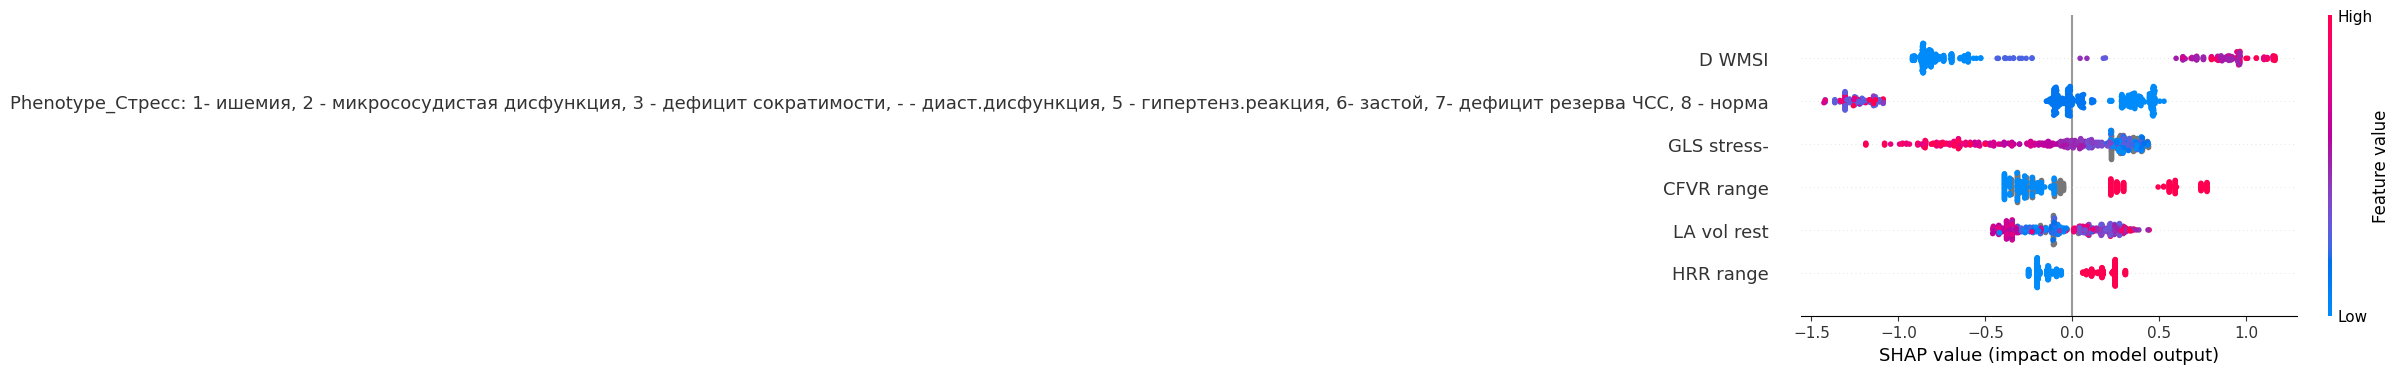

In [ ]:
  # @title Матрица корреляции для отобранных признаков; SHAP
corr_matrix = X_boost.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")

plt.title('Корреляционная матрица признаков')
plt.show()
print()

# Специализированный explainer для деревьев
explainer = shap.TreeExplainer(model)

# SHAP значения для признаков
shap_values = explainer.shap_values(X_boost)

# График важности признаков
shap.summary_plot(shap_values, X_boost)

In [ ]:
# @title PCA для отобранных признаков
fig, axes = plt.subplots(3, 1, figsize=(6, 13))

datasets = [
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# @title Веса главных компонент по всем признакам
data=df_MICE[optimal_cols]
X_numeric = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

for i in range(1, len(X_boost.columns)):
  print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

# print(new_X)
plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False)
plt.title('Тепловая карта нагрузок PCA (первые  компонент)')
plt.show()

In [ ]:
# @title Optuna для XGBoostClassifier
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.4, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True), # Усилили L1
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True), # Усилили L2

        # 2. Позволяем Optuna найти лучший баланс
        # Соотношение 62/29 ≈ 2.14. Ищем вокруг этого значения.
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.5, 3.0),

        # Стандартные параметры
        'use_label_encoder': False,
        'eval_metric': 'logloss' # logloss лучше подходит для оптимизации вероятностей
    }

    model = XGBClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_boost, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)


print("Best trial:")
print("AUC:", study.best_value)
print("Params:", study.best_params)


best_params = study.best_params
best_params['eval_metric'] = 'auc' #не влияет на обучение
model = XGBClassifier(**best_params, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[I 2025-07-12 13:07:35,294] A new study created in memory with name: no-name-44e3473c-02d1-4720-837d-7d307e4e0518


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-07-12 13:07:38,394] Trial 0 finished with value: 0.8062182023742228 and parameters: {'iterations': 749, 'learning_rate': 0.2507596719594366, 'depth': 6, 'l2_leaf_reg': 4.721814157507739, 'random_strength': 3.417298588314596, 'bagging_temperature': 0.41022853657666514, 'border_count': 58, 'scale_pos_weight': 2.128297451172196}. Best is trial 0 with value: 0.8062182023742228.
[I 2025-07-12 13:07:41,483] Trial 1 finished with value: 0.8033643939532086 and parameters: {'iterations': 423, 'learning_rate': 0.13844101423405225, 'depth': 4, 'l2_leaf_reg': 2.9629359915730147, 'random_strength': 9.619793879168261, 'bagging_temperature': 0.4292934696997175, 'border_count': 232, 'scale_pos_weight': 1.731923724216998}. Best is trial 0 with value: 0.8062182023742228.
[I 2025-07-12 13:07:43,363] Trial 2 finished with value: 0.8313171283210854 and parameters: {'iterations': 608, 'learning_rate': 0.024843889018956927, 'depth': 3, 'l2_leaf_reg': 7.352601536185808, 'random_strength': 1.8299548398

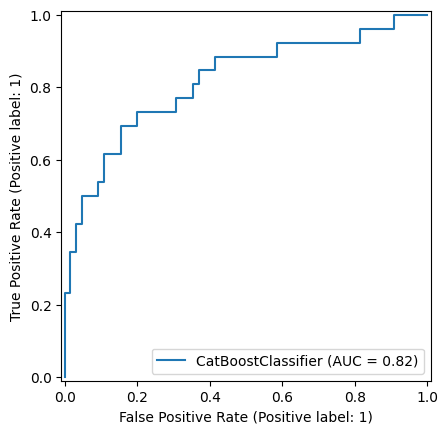

In [ ]:
# @title Optuna для CatBoostClassifier
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 3.0),
        "verbose": False,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "early_stopping_rounds": 50
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_boost, y, cv=cv, scoring="roc_auc")
    return np.mean(auc_scores)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)

# Финальная модель с лучшими параметрами
best_params = study.best_params
best_params.update({
    "loss_function": "Logloss",
    "eval_metric": "Recall",
    "random_seed": 42,
    "early_stopping_rounds": 50,
    "verbose": 100
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Оценка
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# AUC
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()